# Fraud Complete EDA

In [90]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
# Going to only use xgboost for now
# import lightgbm as lgb
# import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

print("Ready!")

Ready!


# Load Data

In [2]:
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
# Ignore the rest since doing EDA for now
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# Utility Functions

In [105]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
       
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [5]:
# reduce memory
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = reduce_mem_usage(test_transaction)

# require for resumetable to work
train_transaction = train_transaction.reset_index()

Mem. usage decreased to 544.60 Mb (69.3% reduction)


# EDA

In [106]:
resumetable(train_transaction)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


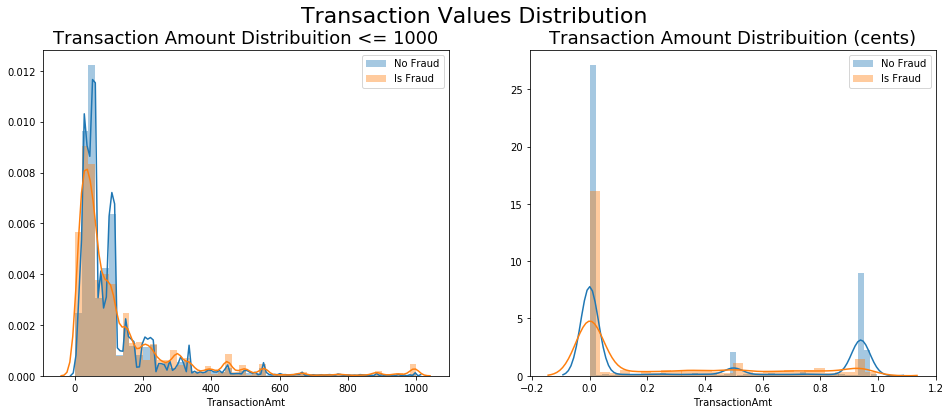

In [100]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Transaction Values Distribution', fontsize=22)

plt.subplot(121)
g1 = sns.distplot(train_transaction[(train_transaction['isFraud'] == 0) & (train_transaction['TransactionAmt'] <= 1000)]['TransactionAmt'])
g1 = sns.distplot(train_transaction[(train_transaction['isFraud'] == 1) & (train_transaction['TransactionAmt'] <= 1000)]['TransactionAmt'])
g1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g1.legend(['No Fraud', 'Is Fraud'])

plt.subplot(122)
g2 = sns.distplot(train_transaction[(train_transaction['isFraud'] == 0) & (train_transaction['TransactionAmt'] <= 1000)]['TransactionAmt'] % 1)
g2 = sns.distplot(train_transaction[(train_transaction['isFraud'] == 1) & (train_transaction['TransactionAmt'] <= 1000)]['TransactionAmt'] % 1)
g2.set_title("Transaction Amount Distribuition (cents)", fontsize=18)
g2.legend(['No Fraud', 'Is Fraud'])

plt.show()


Looks like the cents amount might be helpful

In [56]:
(train_transaction[(train_transaction['isFraud'] == 0)]['TransactionAmt'] % 1).value_counts().head()

0.000000    344349
0.937500    110701
0.500000     26404
0.953125     23007
0.968750      5030
Name: TransactionAmt, dtype: int64

In [57]:
(train_transaction[(train_transaction['isFraud'] == 1)]['TransactionAmt'] % 1).value_counts().head()

0.0000    11722
0.9375      854
0.5000      601
0.8125      307
0.1250      282
Name: TransactionAmt, dtype: int64

# Product Feature

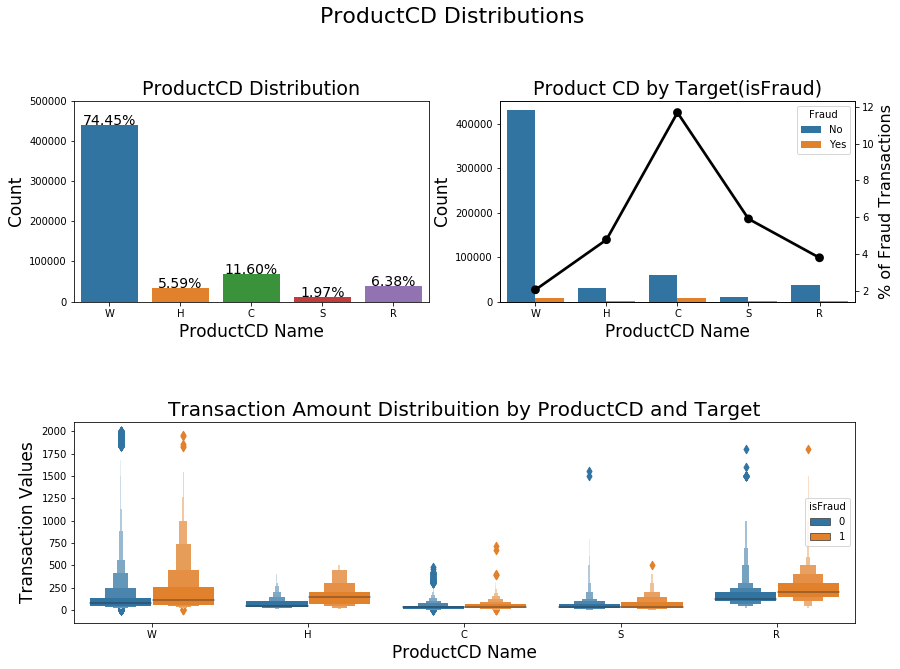

In [68]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()


W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions

# Card Features

In [108]:
card_features = ['card1', 'card2', 'card3','card4', 'card5', 'card6']
resumetable(train_transaction[card_features])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


- card1: numerical
- card2: numerical
- card3: numerical
- card4: categorial (card company)
- card5: numerical
- card6: credit/debit

In [109]:
print("Card Features Quantiles: ")
train_transaction[card_features].quantile([0.01, .025, .1, .25, .5, .75, .975, .99])

Card Features Quantiles: 


,card1,card2,card3,card5
0.010,1338.0,100.0,144.0,102.0
0.025,1675.0,111.0,150.0,102.0
0.100,2803.0,111.0,150.0,126.0
0.250,6019.0,214.0,150.0,166.0
0.500,9678.0,361.0,150.0,226.0
0.750,14184.0,512.0,150.0,226.0
0.975,18018.0,583.0,185.0,226.0
0.990,18238.0,583.0,185.0,226.0


Card 1 and 2 has a large distribution of values, better to get the log of columns

In [143]:
tit

Float64Index([150.0, 185.0, 106.0, 146.0, 144.0, 117.0, 143.0, 119.0, 102.0,
              147.0,
              ...
              199.0, 172.0, 209.0, 101.0, 175.0, 228.0, 139.0, 114.0, 164.0,
              221.0],
             dtype='float64', length=114)